In [1]:
# PSL imports,
import os
import random
import csv

# Third-party imports.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Tensorflow imports,
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras.utils import register_keras_serializable

# Google Colab imports,
from google.colab import drive
from google.colab import output
from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display

# Load Data

In [10]:
# Specifiy mapping,
MAPPING = "DMP-T"

# Functions required to parse the database files,
def parse_example(example_proto):
    feature_description = {
        "X_data": tf.io.VarLenFeature(tf.float32),
        "Y_data": tf.io.VarLenFeature(tf.float32),
        "θ_spec": tf.io.VarLenFeature(tf.float32)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    # Converting sparse tensors to dense tensors,
    x = tf.sparse.to_dense(example["X_data"])
    y = tf.sparse.to_dense(example["Y_data"])
    θ_spec = tf.sparse.to_dense(example["θ_spec"])

    # Shaping tensors,
    X_height, X_width, X_channels = 256, 256, 1
    Y_height, Y_width, Y_channels = 256, 256, 1
    x = tf.reshape(x, (X_height, X_width, X_channels))
    y = tf.reshape(y, (Y_height, Y_width, Y_channels))

    return x, y, θ_spec

def load_tfrecord(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(parse_example)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Mounting drive,
drive.mount('/content/drive', force_remount=True)

# Loading training, test and validation datasets (redshifts CV data found in CosmoMap-v1.4 directory),
train_dataset = load_tfrecord(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/training_dataset({MAPPING}).tfrecord")
test_dataset = load_tfrecord(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/testing_dataset({MAPPING}).tfrecord")
val_dataset = load_tfrecord(f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/validation_dataset({MAPPING}).tfrecord")

Mounted at /content/drive


# Model Architecture & Helper Functions



In [3]:
@register_keras_serializable()
class ResidualBlock(keras.layers.Layer):
    """A residual block is composed of two 3x3 Conv layers with a ReLU activation. The spatial dimensions of the input tensor
    is kept the same as it passes through the block due to same convolutions."""
    def __init__(self, channels, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)

        # Double convolution,
        self.conv1 = keras.layers.Conv2D(channels, (3, 3), padding="same", activation="relu")
        self.conv2 = keras.layers.Conv2D(channels, (3, 3), padding="same", activation=None)

        # Convolution for residual,
        self.res_conv = keras.layers.Conv2D(channels, (1, 1), padding="same", activation=None)

        # ReLU activation function,
        self.relu = keras.layers.ReLU()

    def call(self, x):
        """We define the residual mechanism here. Note that we add the residual to the output of the second 3x3 Conv before
        the ReLU activation."""

        # Extracting and channel matching the residual,
        residual = x
        residual = self.res_conv(residual)

        # Forward pass of the block,
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + residual
        return self.relu(x)

@register_keras_serializable()
class Net(keras.Model):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)

        # Encoder,
        self.resblock1 = ResidualBlock(channels=32)
        self.pool1 = keras.layers.MaxPooling2D((2, 2))

        self.resblock2 = ResidualBlock(channels=64)
        self.pool2 = keras.layers.MaxPooling2D((2, 2))

        self.resblock3 = ResidualBlock(channels=128)
        self.pool3 = keras.layers.MaxPooling2D((2, 2))

        # Bottleneck,
        self.resblock4 = ResidualBlock(channels=256)

        # Decoder,
        self.upconv1 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")
        self.resblock5 = ResidualBlock(channels=128)

        self.upconv2 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")
        self.resblock6 = ResidualBlock(channels=64)

        self.upconv3 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")
        self.resblock7 = ResidualBlock(channels=32)

        # Output
        self.output_layer = keras.layers.Conv2D(1, (1, 1), activation="sigmoid")

    def call(self, inputs):

      # Encoder,
      x1 = self.resblock1(inputs)
      x2 = self.pool1(x1)

      x3 = self.resblock2(x2)
      x4 = self.pool2(x3)

      x5 = self.resblock3(x4)
      x6 = self.pool3(x5)

      # Bottleneck
      x7 = self.resblock4(x6)

      # Decoder
      x8 = self.upconv1(x7)
      x9 = keras.layers.Concatenate()([x8, x5])
      x10 = self.resblock5(x9)

      x11 = self.upconv2(x10)
      x12 = keras.layers.Concatenate()([x11, x3])
      x13 = self.resblock6(x12)

      x14 = self.upconv3(x13)
      x15 = keras.layers.Concatenate()([x14, x1])
      x16 = self.resblock7(x15)

      return self.output_layer(x16)

def SSIM_loss(y_target, y_pred):
    """SSIM loss function."""
    return 1 - tf.reduce_mean(tf.image.ssim(y_target, y_pred, max_val=1.0))

def WMAE_loss(y_target, y_pred, gamma):
    """Weighted MAE loss function."""
    weights = tf.pow(y_target, gamma)
    weighted_MAE = weights * tf.abs(y_target - y_pred)
    return tf.reduce_mean(weighted_MAE)

@register_keras_serializable()
def hybrid_loss(y_target, y_pred, alpha=0.5, beta=0.5, gamma=2):
    """Hybrid loss function which is a weighted sum of SSIM and WMAE loss."""
    return alpha*SSIM_loss(y_target, y_pred) + beta*WMAE_loss(y_target, y_pred, gamma)

def initialise_weights(model):
  """Weight initialisation for convolutional layers."""
  for layer in model.layers:
      if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
          # Extracting the current weights and biases,
          weights, biases = layer.get_weights()

          # Reinitialising weights with He Normal initialisation,
          initializer = tf.keras.initializers.HeNormal()
          new_weights = initializer(shape=weights.shape)

          # Set the new weights while keeping the original biases,
          layer.set_weights([new_weights, biases])

def compute_validation_loss(validation_data, alpha, beta, gamma):
    """Computes the loss on the validation dataset. This is done at the end of every epoch."""

    # Creating dataloader for validation dataset,
    val_dataset = validation_data.shuffle(buffer_size=10000).batch(BATCH_SIZE)

    # Creating variable to sum up batch losses,
    accumulated_loss = 0

    for step, (X_batch, Y_batch, θ_spec_batch) in enumerate(val_dataset):

        # Model forward pass,
        Y_pred_val = model(X_batch, training=False)

        # Computing batch loss,
        batch_val_loss = hybrid_loss(Y_batch, Y_pred_val, alpha, beta, gamma)

        # Accumlating loss,
        accumulated_loss += batch_val_loss.numpy()

    # Computing total loss,
    val_loss = accumulated_loss/(step + 1)

    return val_loss

def model_predict_sample(model, testing_data, i):
    """This function is allows the model to make a prediction on the ith sample of the testing dataset only """

    # Pulling out the sample,
    sample = list(testing_data.skip(i).take(1))

    # Extracing X from (X, Y, θ_spec) group in the sample,
    for (X, Y, θ_spec) in sample:

      # Extracting redshift label,
      redshift_label = θ_spec[0].numpy()

      # Reformatting and shaping the data tensor,
      data = np.transpose(X.numpy(), (2, 0, 1))

      # Reformatting and shaping the target tensor,
      target = np.squeeze(Y.numpy(), axis=-1)

      # Adding batch dimension (batch_size = 1),
      X = tf.expand_dims(X, axis=0)

      # Model forward pass,
      pred = model(X, training=False)

      # Removing channel and batch dimension,
      pred = tf.squeeze(pred, axis=0)
      pred = tf.squeeze(pred, axis=-1).numpy()

      return data, pred, target, redshift_label

# Initialise/View Model

In [11]:
"""SPECIFICATIONS"""
MAPPING = "DM-T"
MODEL_VERSION = "FINAL"
MODEL_NAME = f"{MAPPING}-v{MODEL_VERSION}"
EXISTING_MODEL = True
EXISTING_MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/CosmoMap (DM-T).keras"

if EXISTING_MODEL:
  # Loading model instance,
  model = keras.models.load_model(EXISTING_MODEL_PATH)
else:
  # Creating model instance,
  model = Net()

# Creating checkpoint path,
CHECKPOINT_PATH = f"/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/{MODEL_NAME}-CHECKPOINTS/"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Creating example image tensor,
X = tf.random.normal((1, 256, 256, 1))

# Passing random tensor into model (TensorFlow uses channel last scheme),
model(X, training=False)

# Print model summary.
model.summary()

Model: "net_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ residual_block_14               │ ?                      │         9,632 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_15               │ ?                      │        57,536 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_16               │ ?                      │       229,760 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_17               │ ?                      │       918,272 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (1, 64, 64, 128)       │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_18               │ ?                      │       475,520 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (1, 128, 128, 64)      │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_19               │ ?                      │       118,976 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (1, 256, 256, 32)      │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_20               │ ?                      │        29,792 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (1, 256, 256, 1)       │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,035,333 (23.02 MB)

 Trainable params: 2,011,777 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,023,556 (15.35 MB)

# Train Model

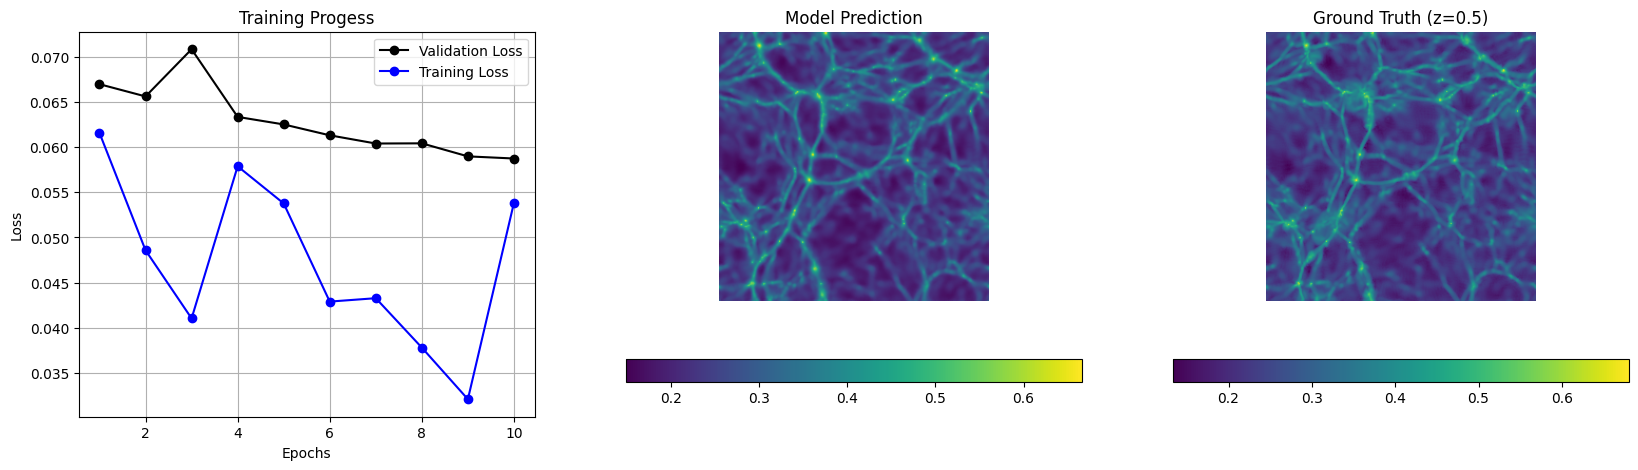

Epoch: 10, Training Loss: 0.05383986234664917, Validation Loss: 0.05875479802489281


In [ ]:
"""HYPERPARAMERS"""
N_EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
ALPHA = 0.8
BETA = 0.2
GAMMA = 2

# Starting epoch,
START_EPOCH = 1

# Creating dataloader,
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)

if EXISTING_MODEL:
  # Creating optimiser,
  optimiser = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

  # Loading model,
  model = keras.models.load_model(EXISTING_MODEL_PATH)

else:
  # Creating optimiser,
  optimiser = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

  # Weight initialisation,
  initialise_weights(model)

# Tracking validation loss and epoch,
val_losses = []
train_losses = []
epochs = []

# Creating logging file,
LOGGING_FILE = os.path.join(CHECKPOINT_PATH, f"{MODEL_NAME}-LOGGING.csv")
os.makedirs(os.path.dirname(LOGGING_FILE), exist_ok=True)
with open(LOGGING_FILE, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Training Loss", "Validation Loss"])

# Training loop (epoch level),
for epoch in range(START_EPOCH, (START_EPOCH + N_EPOCHS)):

    # Training loop (batch_level),
    for step, (X_batch, Y_batch, θ_spec_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:

            # Model forward pass,
            Y_pred = model(X_batch, training=True)

            # Computing loss,
            loss = hybrid_loss(Y_batch, Y_pred, ALPHA, BETA, GAMMA)

        # Computing gradients,
        gradients = tape.gradient(loss, model.trainable_variables)

        # Updating weights,
        optimiser.apply_gradients(zip(gradients, model.trainable_variables))

    # Computing validation loss,
    val_loss = compute_validation_loss(val_dataset, ALPHA, BETA, GAMMA)
    val_losses.append(val_loss)

    # Tracking epoch and loss,
    train_losses.append(loss)
    epochs.append(epoch)

    # Saving checkpoint,
    model.compile(optimizer=optimiser, loss=hybrid_loss)
    model.save(os.path.join(CHECKPOINT_PATH, f"checkpoint-epoch{epoch}.keras"))

    """GRAPHING"""

    # Clear previous input,
    clear_output(wait=True)

    # Model prediction on test sample,
    random_sample = random.randint(0, 50)
    data, pred, target, redshift_label = model_predict_sample(model, test_dataset, random_sample)

    # Creating figures,
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot titles,
    titles = ["Model Prediction", f"Ground Truth (z={redshift_label})"]

    # Plotting each image,
    for ax, img, title in zip(axes[-2:], [pred, target], titles):
      img_obj = ax.imshow(img, cmap = "viridis")
      ax.set_title(title)
      ax.axis("off")
      fig.colorbar(img_obj, ax=ax, orientation="horizontal")

    # Plotting training progress,
    axes[0].plot(epochs, val_losses, label="Validation Loss", color="black", marker='o')
    axes[0].plot(epochs, train_losses, label="Training Loss", color="blue", marker='o')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training Progess")
    axes[0].legend()
    axes[0].grid()

    # Displaying plot,
    plt.show()

    # Writing to logging file,
    try:
      with open(LOGGING_FILE, mode="a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([int(epoch), float(loss), float(val_loss)])
    except:
      print(f"Could not write to {LOGGING_FILE} file!")

    # Print statement,
    print(f"Epoch: {epoch}, Training Loss: {loss}, Validation Loss: {val_loss}")

# Results & Preliminary Analysis

In [12]:
# Setting inital i value,
N_BINS = 100
i = 0

def update_plot(i):

  # Model prediction,
  _, prediction, target, redshift_label = model_predict_sample(model, test_dataset, i)

  # Creating figure,
  fig, axes = plt.subplots(1, 3, figsize=(20, 5))

  # Creating histograms,
  axes[0].hist(prediction.flatten(), bins=N_BINS, color="blue", alpha=0.5, label="Prediction")
  axes[0].hist(target.flatten(), bins=N_BINS, color="red", alpha=0.5, label="Ground Truth")
  axes[0].set_xlabel("Pixel Intensity")
  axes[0].set_ylabel("Frequency")
  axes[0].set_title("Pixel Intensity Distribution")
  axes[0].legend()

  # Plotting images,
  img_pred = axes[1].imshow(prediction, cmap="viridis", vmax=0.7)
  axes[1].set_title("Prediction")
  axes[1].axis("off")
  fig.colorbar(img_pred , orientation="vertical", shrink=0.75)

  img_target = axes[2].imshow(target, cmap="viridis", vmax=0.7)
  axes[2].set_title(f"Ground Truth ($z=${redshift_label})")
  axes[2].axis("off")
  fig.colorbar(img_target, orientation="vertical", shrink=0.75)

  # Displaying plot,
  plt.tight_layout()
  plt.show()

# Creating slider,
slider = widgets.IntSlider(value=i, min=0, max=100, step=1, description="Test Sample")

# Display interactive output,
interactive_plot = widgets.interactive_output(update_plot, {"i":slider})

# Display slider and plot,
display(slider, interactive_plot)

IntSlider(value=0, description='Test Sample')

Output()

# Regression

In [ ]:
# Setting inital i value,
N_BINS = 100
i = 1

# Min-max parameters,
Y_min, Y_max = 2, 9 #(DM-T)
#Y_min, Y_max = -9, -1 #(DM-Ne)

def update_plot(i):

  # Model prediction,
  _, prediction, target, redshift_label = model_predict_sample(model, test_dataset, i)

  # Undo log normalisation and min-max scaling,
  prediction = 10**(prediction*(Y_max - Y_min) + Y_min)
  target = 10**(target*(Y_max - Y_min) + Y_min)

  # Creating figure,
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))

  # Creating histograms,
  axes[0].hist(np.log(prediction).flatten(), bins=N_BINS, color="blue", alpha=0.5, label="Prediction")
  axes[0].hist(np.log(target).flatten(), bins=N_BINS, color="red", alpha=0.5, label="Ground Truth")
  axes[0].set_xlabel("Pixel Intensity")
  axes[0].set_ylabel("Frequency")
  axes[0].set_title("Pixel Intensity Distribution")
  axes[0].legend()

  # Plotting images,
  ratio = prediction/target
  img_ratio = axes[1].imshow(ratio, cmap="bwr", norm=colors.LogNorm(vmin=0.1, vmax=10))
  axes[1].set_title("Ratio")
  axes[1].axis("off")
  fig.colorbar(img_ratio, orientation="horizontal", )

  img_pred = axes[2].imshow(np.log10(prediction), cmap="inferno")
  axes[2].set_title("Prediction")
  axes[2].axis("off")
  fig.colorbar(img_pred, orientation="horizontal")

  img_target = axes[3].imshow(np.log10(target), cmap="inferno")
  axes[3].set_title(f"Ground Truth ($z=${redshift_label})")
  axes[3].axis("off")
  fig.colorbar(img_target, orientation="horizontal")

  # Displaying plot,
  plt.tight_layout()
  plt.show()

# Creating slider,
slider = widgets.IntSlider(value=i, min=0, max=100, step=1, description="Test Sample")

# Display interactive output,
interactive_plot = widgets.interactive_output(update_plot, {"i":slider})

# Display slider and plot,
display(slider, interactive_plot)

IntSlider(value=1, description='Test Sample')

Output()

# Testing Dataset Results

In [7]:
# Specify number of samples,
N_SAMPLES = 512
predictions = []
targets = []
DMD_data = []
pred_redshifts = []

# Min-max parameters,
#Y_min, Y_max = 2, 9 #(DM-T)
Y_min, Y_max = -9, -1 #(DM-Ne)

for i in range(N_SAMPLES):

  # Model prediction,
  data, prediction, target, redshift_label = model_predict_sample(model, test_dataset, i)

  # Undo log normalisation and min-max scaling,
  prediction = 10**(prediction*(Y_max - Y_min) + Y_min)
  target = 10**(target*(Y_max - Y_min) + Y_min)

  # Appending,
  predictions.append(prediction)
  pred_redshifts.append(redshift_label)
  targets.append(target)
  DMD_data.append(data)

# Converting to NumPy arrays,
predictions = np.array(predictions)
targets = np.array(targets)
DMD_data = np.array(DMD_data)
pred_redshifts = np.array(pred_redshifts)

# Saving predictions to file,
np.save(os.path.join("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/", f"predictions({MAPPING}).npy"), predictions)
np.save(os.path.join("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/", f"targets({MAPPING}).npy"), targets)
np.save(os.path.join("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/", f"DMD_data.npy"), DMD_data)
np.save(os.path.join("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/", "predictions_z.npy"), pred_redshifts)

KeyboardInterrupt: 

# Simulation Predictions

In [13]:
MAPPING_TO = "T"

def model_predict(X, X_min, X_max, Y_min, Y_max, redshift):
  """Returns the model prediction on a image."""

  # Log scaling,
  X = np.log10(X)

  # Min-Max normalisation,
  X = (X - X_min)/(X_max - X_min)

  # Adding batch channel,
  X = np.expand_dims(X, axis=0)

  # Adding channel dimension,
  X = np.expand_dims(X, axis=-1)

  # Converting to Tensor,
  X = tf.convert_to_tensor(X)

  # Model forward pass,
  Y_pred = model(X, training = False)

  # Removing channel dimension,
  Y_pred = np.squeeze(Y_pred.numpy(), axis=-1)

  # Removing batch dimension,
  Y_pred = np.squeeze(Y_pred, axis=0)

  # Reversing Min-Max normalisation,
  Y_pred = Y_pred*(Y_max - Y_min) + Y_min

  # Reversing Log scaling,
  Y_pred = 10**Y_pred

  return Y_pred

# Target normalisation parameters,
X_min, X_max = 4, 17 #(DMD)
#Y_min, Y_max = -9, -1 #(DM-Ne)
Y_min, Y_max = 2, 9 #(DM-T)

# REDSHIFTS,
redshifts = [0.0, 0.5, 1.0, 1.5, 2.0]

# Mounting drive,
drive.mount('/content/drive', force_remount=True)

# Loading grids,
DMD_grid_z0 = np.load("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=0.0.npy")
DMD_grid_z05 = np.load("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=0.5.npy")
DMD_grid_z10 = np.load("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=1.0.npy")
DMD_grid_z15 = np.load("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=1.5.npy")
DMD_grid_z20 = np.load("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/DMD-CV0-z=2.0.npy")

# Creating dictionaries for the DMPs where the key is the redshift label,
DMD_grids = {"0.0": DMD_grid_z0, "0.5": DMD_grid_z05, "1.0": DMD_grid_z10, "1.5": DMD_grid_z15, "2.0": DMD_grid_z20}

# Model predictions,
for redshift in redshifts:
  pred = np.zeros((DMD_grid_z0.shape[0], 256, 256))
  for i in range(DMD_grid_z0.shape[0]):

    # Extracting the DMP grids based on redshift label,
    DMD_grid = DMD_grids[str(redshift)]

    # Model forward pass,
    img_pred = model_predict(X=DMD_grid[i], X_min=X_min, X_max=X_max, Y_min=Y_min, Y_max=Y_max, redshift=redshift)
    pred[i] = img_pred

  # Saving model prediction,
  FILE_NAME = f"{MAPPING_TO}-CV0-z={redshift}-pred.npy"
  np.save(os.path.join("/content/drive/My Drive/Colab Notebooks/CosmoMap-PM1.6/", FILE_NAME), pred)

Mounted at /content/drive
